In [1]:
import torch
from torch import nn
from torch.nn import functional as F

# Pytorch Tensors

Why do we use tensors? Because they have gradients, so when you perform any operation with the tensor, pytorch does the math and stores in the tensor what it has done and how to backpropagate. 

In [2]:
# 1D Tensor (28)
y = torch.tensor([i for i in range(28)])
print(y)
print(y.size())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27])
torch.Size([28])


In [3]:
# 2D Tensor 28x28 (for example an image of 28 by 28 pixels)
x = torch.tensor([[i for i in range(28)] for _ in range(28)])
print(x.size())

torch.Size([28, 28])


In [4]:
# We can reshape the tensor with the view function
# A good way of using view is using -1 as its first arg, because this flattens out the tensor

x1 = x.view(-1) # Will go from 2D to 1D
x2 = x.view(-1,784) # Will stay in 2D

print(x1.size())
print(x2.size())

torch.Size([784])
torch.Size([1, 784])


In [5]:
# Tensor Calculations

a = torch.tensor([0,1])
b = torch.tensor([1,0])

print(a @ b)

c = torch.tensor([[1,2,3], [4,5,6]])

print(c[1][1])

# Prints out a tensor, in order to get just the actual value:

print(c[1][1].item())

tensor(0)
tensor(5)
5


# Simple datasets and Dataloaders

With almost any form of data worth feeding a neural network, preprocessing is essential. PyTorch handles this with an object it calls the "Dataset". Later in this tutorial, we will see how to build our own dataset. For now, we'll use one of their provided datasets so we can examine the objects torch provides.

Tensors go into datasets via the "Dataset" object (take care of the preprocessing) and then we feed this dataset into another object called the "Dataloader". So we have to import two essential things to make this work.

In [6]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader 
from torchvision.transforms import ToTensor
import numpy as np 

import tqdm
from tqdm.notebook import trange
!jupyter nbextension enable --py widgetsnbextension

from PIL import Image #To see images externally
import matplotlib.pyplot as plt #To see images in notebook
%matplotlib inline  

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
# Load the fashion MNIST dataset
# The root argument is to let the function know where we want to store the data

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
)

In [8]:
# This will say which image and which label

train_data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB0FB175B20>, 9)

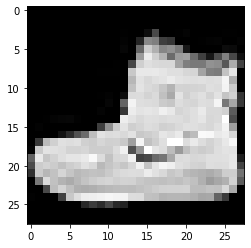

In [9]:
# To see how the image looks like

img = train_data[0][0]
plt.imshow(img, cmap='gray')
plt.show()

Training data in its raw form is an image object (not so useful because we can't feed it in a NN) and this is why we transform it to a Tensor:

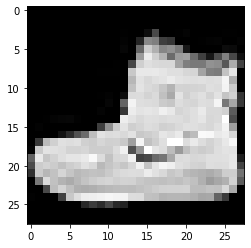

In [10]:
trans = ToTensor()
img = trans(train_data[0][0])
plt.imshow(img.squeeze(), cmap='gray') # In this case we have to use squeeze because tensor is (1x28x28) (removes 1)
plt.show()

Luckily we can do this from the beginning when loading the data:

In [25]:
train_data = datasets.FashionMNIST( 
    root = "data", 
    train = True, 
    download = True, 
    transform = ToTensor() 
) 
test_data = datasets.FashionMNIST( 
    root = "data", 
    train = False, 
    download = True, 
    transform = ToTensor() 
) 

print("training data length:", len(train_data)) 
print("test data length:", len(train_data)) 

training data length: 60000
test data length: 60000


In [26]:
img = train_data[0][0]
img.shape

torch.Size([1, 28, 28])

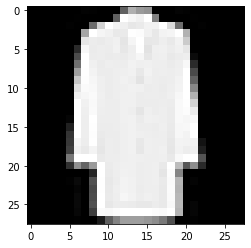

In [27]:
rand = np.random.randint(len(train_data)) 
plt.imshow(train_data[rand][0].squeeze(), cmap='gray') 
plt.show()

We also want to feed in the images in batches, and that is where the dataloader comes in. The dataloader is made to be iterated, so we have to build a for loop.

In [28]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle=True) 
test_loader = DataLoader(test_data, batch_size = len(train_data), shuffle=True) 

In [29]:
for x, label in train_loader: 
    print("Image shape is ",x.shape) 
    print("Labels shape is ",label.shape) 
    break 

Image shape is  torch.Size([16, 1, 28, 28])
Labels shape is  torch.Size([16])


Another problem is that we can't feed an image to a NN (because it is 28x28 tensor) so we have to make a 1D tensor, so don't forget this! The above tells us that we have to resize the images once more, to flatten them into single-dimensional tensors.

In [30]:
for x, label in train_loader:
    x = x.reshape(-1,28*28)
    print("Image shape is ",x.shape)
    print("Labels shape is ",label.shape)
    break

Image shape is  torch.Size([16, 784])
Labels shape is  torch.Size([16])


# Simple Model Creation

In [43]:
# Two Ways of doing this, both of them do the exact same thing
# Only a syntax difference, so your choice

# We can make NNs look like regular python classes

### FIRST OPTION #######

class BasicNeuralNet1(nn.Module):
    def __init__(self):
        super(BasicNeuralNet1, self).__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784) # depends on whether you cleaned x before or not
        x = torch.sigmoid(self.layer1(x)) # Activation function
        x = self.layer2(x)
        return F.log_softmax(x, 0)
    
    
### SECOND OPTION #######
### THIS COULD BE HANDY FOR AN AUTOENCODER #####

class BasicNeuralNet2(nn.Module):
    def __init__(self):
        super(BasicNeuralNet2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.Sigmoid(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layer1(x)
        return self.layer2(x)

# Train that Model! (The two key pieces)

The two fundamental things here are the loss function and the optimizer (how it should improve). PyTorch has an extensive library with many different loss functions and optimizers.

It's traditional to have a big list of hyperparameters

In [44]:
model = BasicNeuralNet1()
learning_rate = 0.05
epochs = 10

MSELoss = torch.nn.MSELoss()
CELoss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

It's also good to define a test/accuracy function, to keep tabs on how the model is doing

In [45]:
def get_accuracy(output, targets): 
    """
    calculates accuracy from model output and targets 
    
    """ 
    output = output.detach() # Detach the predictions from the models to get rid of the gradients
    predicted = output.argmax(-1) 
    correct = (predicted == targets).sum().item() # Sum up the number of correct values
    accuracy = correct / output.size(0) * 100 
    return accuracy 

Use the trange-function from tqdm.notebook, because it is a very handy function for visualizing progress. It acts just like the normal python "range", except it displays a progress bar.

In [54]:
for epoch in range(epochs): 
    
    # Very important to put this in the beginning, 
    # because we want the gradients to be available
    model.train()
    
    for data, labels in train_loader: 
        # Clear out the gradients before doing the forward and backward pass 
        # because we have to zero out the gradients from previous training
        optimizer.zero_grad() 
        
        # run data through model 
        preds = model(data) 
        
        # compare predictions to actual labels 
        loss = CELoss(preds,labels) 
        
        # After we have found the predictions and found the loss
        # we have to backpropogate the loss 
        loss.backward() 
        
        # Adjust the model parameters via the optimizer
        # To update the parameters
        optimizer.step() 
        
    # After each epoch, it's nice to see how our model is doing 
    model.eval() # disables gradient computations during testing + speeds things up
    test_data, test_labels = next(iter(test_loader)) 
    test_data = test_data.reshape(-1,784) 
    test_preds = model(test_data) 
    test_acc = get_accuracy(test_preds,test_labels) 
    train_acc = get_accuracy(preds, labels) 
    print(f"Epoch {epoch}. Train Acc {train_acc}% | Test Acc {test_acc}") 

Epoch 0. Train Acc 93.75% | Test Acc 75.56
Epoch 1. Train Acc 68.75% | Test Acc 77.66999999999999
Epoch 2. Train Acc 68.75% | Test Acc 77.64
Epoch 3. Train Acc 62.5% | Test Acc 76.06
Epoch 4. Train Acc 68.75% | Test Acc 77.98
Epoch 5. Train Acc 87.5% | Test Acc 78.36999999999999
Epoch 6. Train Acc 87.5% | Test Acc 79.94
Epoch 7. Train Acc 87.5% | Test Acc 78.91
Epoch 8. Train Acc 81.25% | Test Acc 76.83
Epoch 9. Train Acc 75.0% | Test Acc 78.39
